# RLab05 - Gabriele Bertinelli (2103359)

In [1]:
library(tidyverse)
library(gridExtra)
library(latex2exp)
library(emdbook)
library(bayestestR)
library(coda)
library(magrittr)
library(rjags)

set.seed(2103359)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Caricamento pacchetto: 'gridExtra'


Il seguente oggetto è mascherato da 'package:dplyr':

    combine



Caricamento pacchetto: 'magrittr'


Il seguente oggetto è mascherato da 'package:purrr':

    set_names


Il seguente oggetto è mascherato da 'package:tidyr':

    extract


Linked to JAGS 4.3.1

Loaded modules: basemod,bugs



#### 1) 

In [2]:
my.mcmc <- function(func = func, mu.init = mu.init, n.iter = n.iter, burn.in = burn.in, thinning = thinning, norm = FALSE) {
  # Initialize chain and acceptance counter
  mu.cur <- mu.init
  func.samp <- matrix(data=NA, nrow=n.iter, ncol=4)
  func.samp[1:2, 2] <- c(mu.cur, mu.cur)
  n.acc <- 0
  acc.rate <- 0
  
  func.samp[1:2, 1] <- c(1, 2)
    
  # Loop for MCMC iterations
  for (i in 3:n.iter) {
    # Propose new value for mu
    mu.prop <- rnorm(1, func.samp[i-1, 2], 1)
      
    # Calculate acceptance probability ratio
    rho <- min(1, func(mu.prop, norm) / func(func.samp[i-1, 2], norm)) 

    # Accept or reject proposal based on uniform random draw
    if (runif(1) < rho) {
      func.samp[i, 2] <- mu.prop
      n.acc <- n.acc + 1
    } else {
      func.samp[i, 2] <- func.samp[i-1, 2]
    }
	func.samp[i, 1]	<- i
	func.samp[i, 3] <- n.acc
	func.samp[i, 4] <- n.acc / i
  }
  
    # Remove burn-in (initial samples for convergence)
      start <- round(n.iter * burn.in)
      func.samp <- func.samp[start:n.iter, ]
      
      # Apply thinning
      func.samp <- func.samp[seq(1, nrow(func.samp), by=thinning), ]
      
      # Return thinned MCMC chain, acceptance rate, and ACF
      return(func.samp)
}

In [3]:
post.func <- function(theta, norm=FALSE) {

    if (norm==FALSE) {

		return(1/2*exp(-((theta+3)^2)/2) + 1/2*exp(-((theta-3)^2)/2)) #unnormalized post
	}

    else {
	# integ <- integrate(u.post, -Inf, +Inf)$value
	# print(integ)
    integ <- sqrt(2*pi)

    return((1/2*exp(-((theta+3)^2)/2) + 1/2*exp(-((theta-3)^2)/2)) / integ) #normalized post
    }
}

In [4]:
theta.init <- rnorm(1, 0, 1)  # Initial value for theta
thinning <- 1
burn.in <- 0.15
test.chain <- my.mcmc(func = post.func, mu.init = rnorm(1,0,1), n.iter = 100000, burn.in = burn.in, thinning=thinning, norm=F) 
test.chain <- as.data.frame(test.chain)
colnames(test.chain) <- c('it', 'theta', 'n.acc', 'acc.rate')

print(length(test.chain[,1]))

[1] 85001


In [5]:
posterior.mean <- mean(test.chain$theta) # must be centered in 0

posterior.sd <- sd(test.chain$theta)
x_min <- posterior.mean - posterior.sd # true value is x=-3
x_max <- posterior.mean + posterior.sd # true value is x=+3

cat("Posterior Mean:", round(posterior.mean, 2), "\n")
cat("Posterior Standard Deviation:", round(posterior.sd, 2), "\n")
print(sprintf("Firs max is at x=%.2f Second max is at x=%.2f", x_min, x_max))

Posterior Mean: 0.18 
Posterior Standard Deviation: 3.17 
[1] "Firs max is at x=-2.99 Second max is at x=3.35"


In [6]:
# cred.int <- quantile(test.chain$theta, c(0.025, 0.975))

# cat("95% Credible Interval:", round(cred.int[1], 2), '-', round(cred.int[2], 2), "\n")

Acceptance Rate: 0.71276 


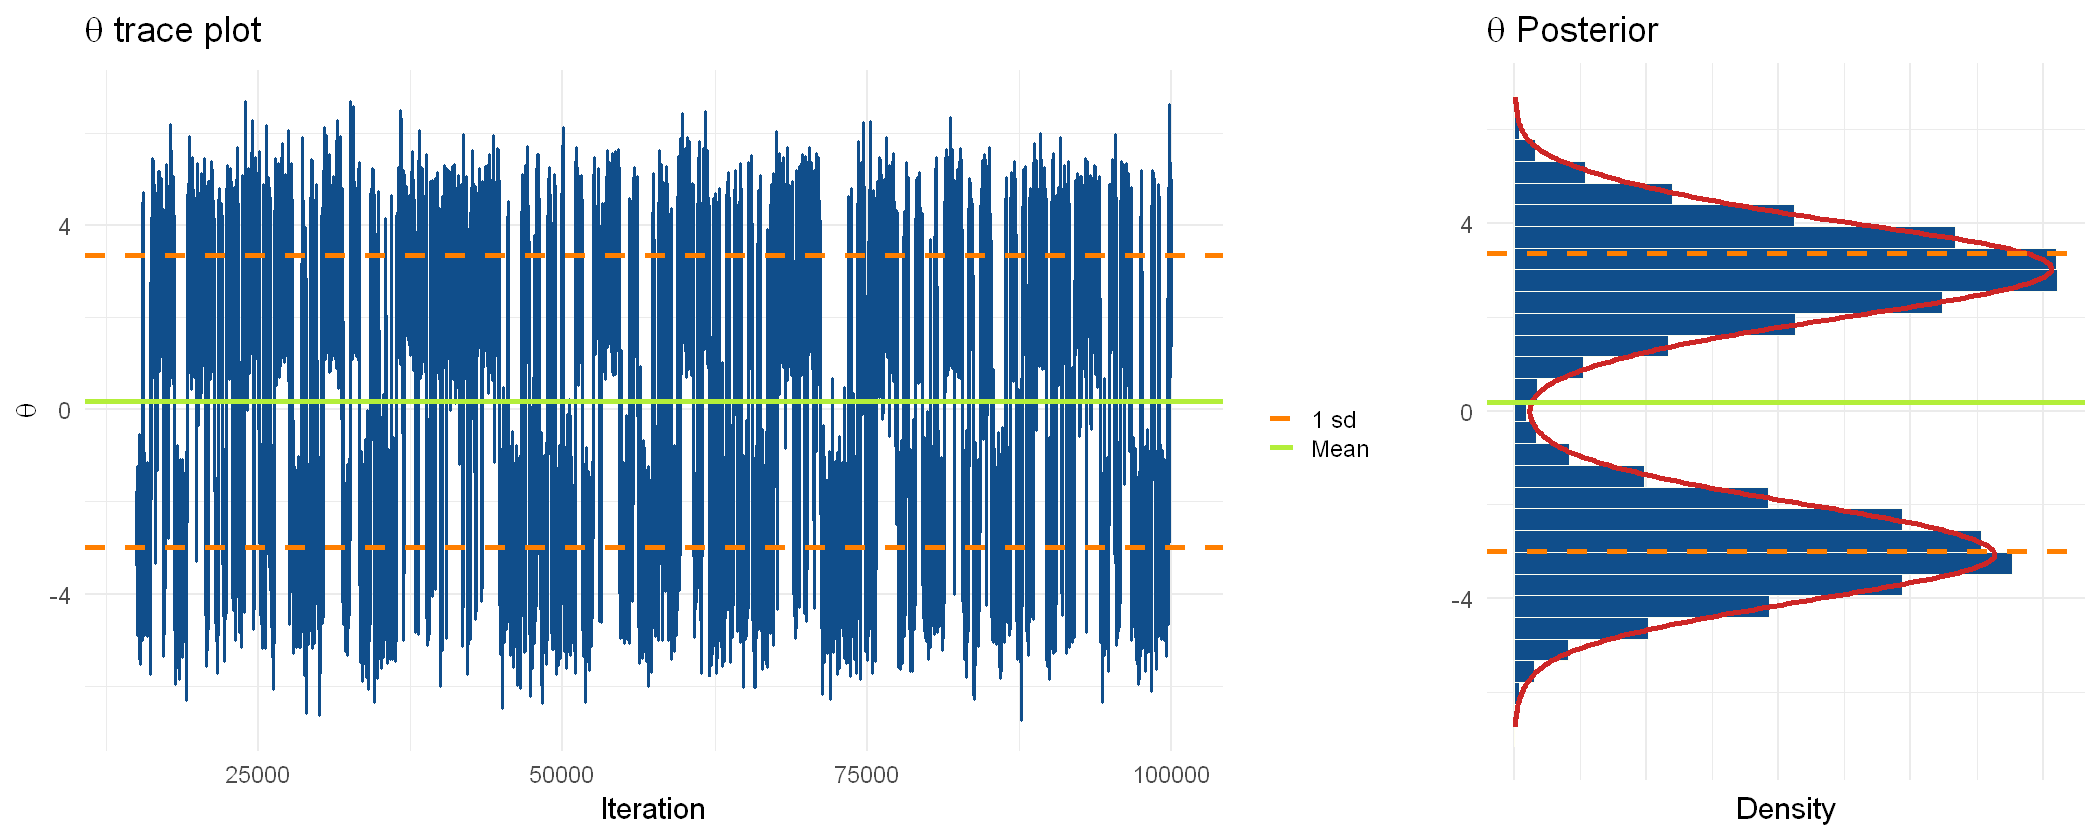

In [7]:
# Print acceptance rate
cat("Acceptance Rate:", tail(test.chain$acc.rate, 1), "\n")

options(repr.plot.width = 17.5, repr.plot.height = 7)

# Custom layout
layout <- matrix(c(1, 1, 2), ncol = 3, byrow = TRUE)

# Visualize posterior distribution
post.hist <- ggplot(data = test.chain) +
	geom_histogram(aes(x = theta, after_stat(density)), bins = 30, color = "ivory", fill = "dodgerblue4") +
	geom_density(aes(x = theta), color = "firebrick3", lwd = 1.5) +
	geom_vline(aes(xintercept = posterior.mean, color='Mean'), lwd=1.5)+
	geom_vline(aes(xintercept = posterior.mean - posterior.sd, color='1 sd'), lwd=1.5, linetype='dashed') +
	geom_vline(aes(xintercept = posterior.mean + posterior.sd, color='1 sd'), lwd=1.5, linetype='dashed') +
	# geom_vline(aes(xintercept = posterior.median, color='Median'), lwd=1.5) +
	# geom_vline(aes(xintercept = cred.int[1], color='95% CI'), lwd=1.5, linetype='dotdash') +
	# geom_vline(aes(xintercept = cred.int[2], color='95% CI'), lwd=1.5, linetype='dotdash') +
	labs(title = TeX(r"(\theta Posterior)"), x = '', y = "Density") +
	scale_color_manual(values = c('Mean' = 'olivedrab2', '1 sd' = '#FF7F00', '95% CI' = 'violetred3')) +
	theme_minimal(base_size = 18) + theme(axis.text.x=element_blank(), legend.position="none") + coord_flip()

trace.plot <- ggplot(data = test.chain) +
	geom_line(aes(x = it, y = theta), color = "dodgerblue4", lwd=1) +
	geom_hline(aes(yintercept = posterior.mean, color='Mean'), lwd=1.5)+
	geom_hline(aes(yintercept = posterior.mean - posterior.sd, color='1 sd'), lwd=1.5, linetype='dashed') +
	geom_hline(aes(yintercept = posterior.mean + posterior.sd, color='1 sd'), lwd=1.5, linetype='dashed') +
	# geom_hline(aes(yintercept = posterior.median, color='Median'), lwd=1.5) +
	# geom_hline(aes(yintercept = cred.int[1], color='95% CI'), lwd=1.5, linetype='dotdash') +
	# geom_hline(aes(yintercept = cred.int[2], color='95% CI'), lwd=1.5, linetype='dotdash') +
	labs(title = TeX(r"(\theta trace plot)"), x = "Iteration", y = TeX(r"(\theta)"), color='', lwd=1.5) +
	scale_color_manual(values = c('Mean' = 'olivedrab2', '1 sd' = '#FF7F00', '95% CI' = 'violetred3')) +
	theme_minimal(base_size = 18)

grid.arrange(trace.plot, post.hist, layout_matrix = layout)

In [8]:
test.mcmc <- coda::mcmc(test.chain$theta)
my.lags <- seq(0, length(test.mcmc)-1, 10)
y1 <- autocorr(test.mcmc, lags=my.lags)

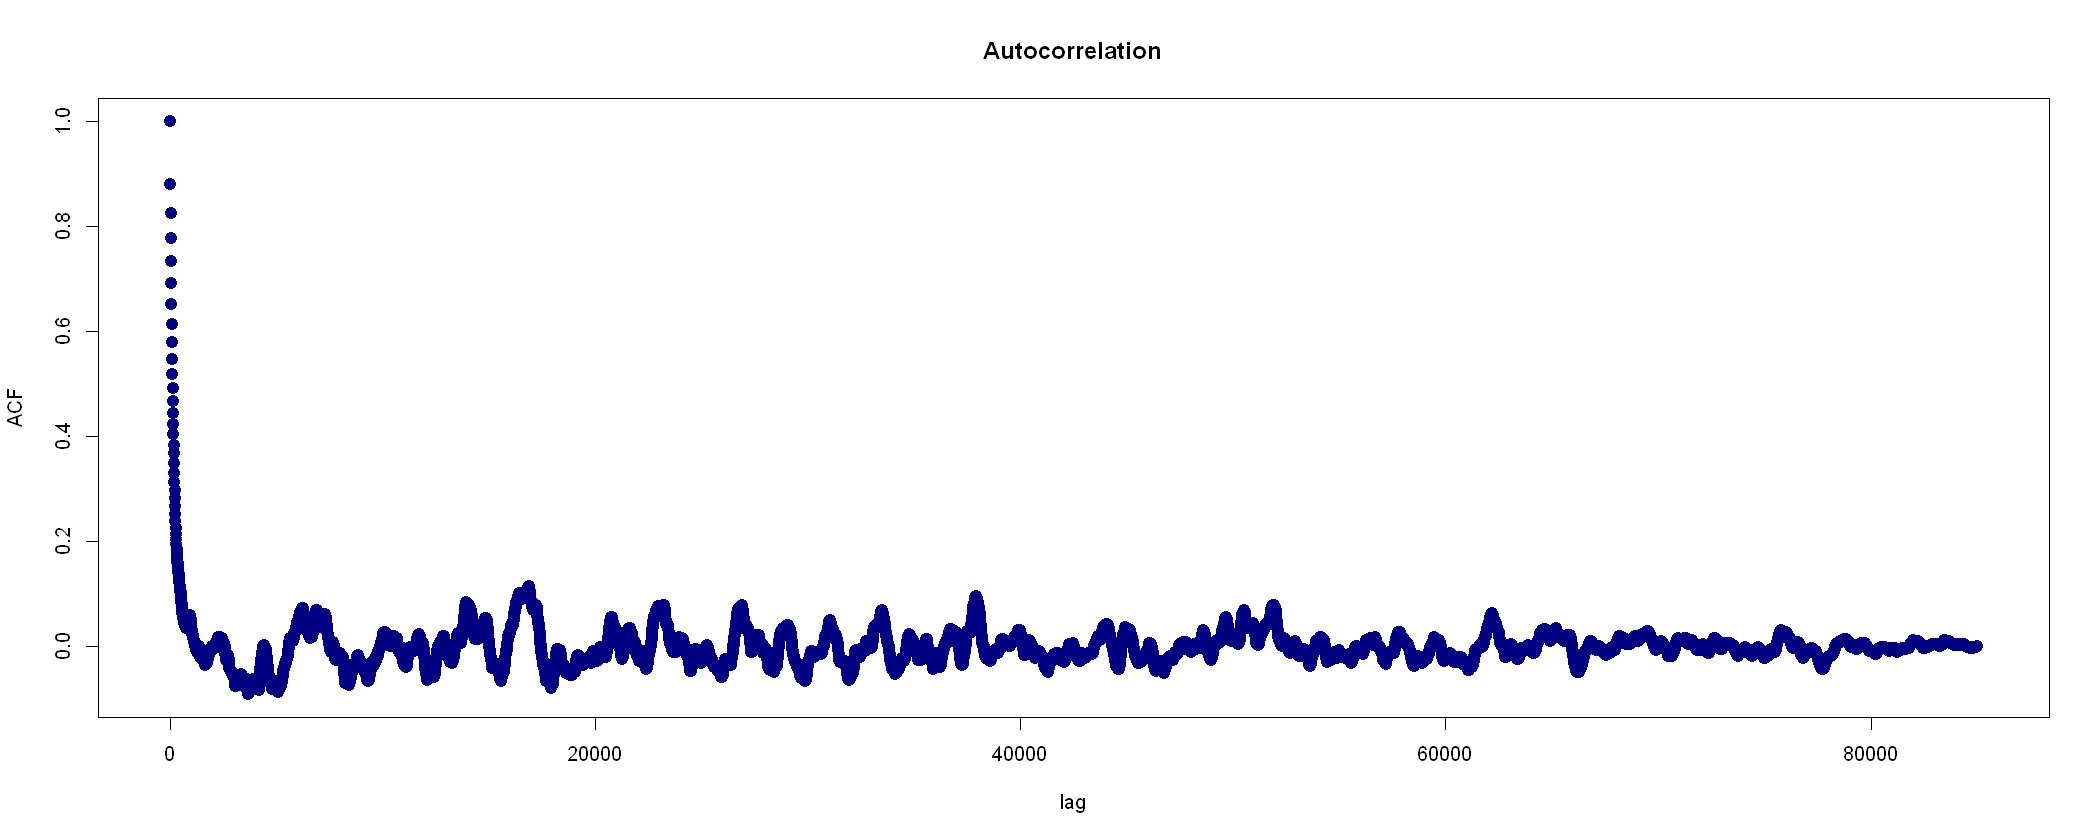

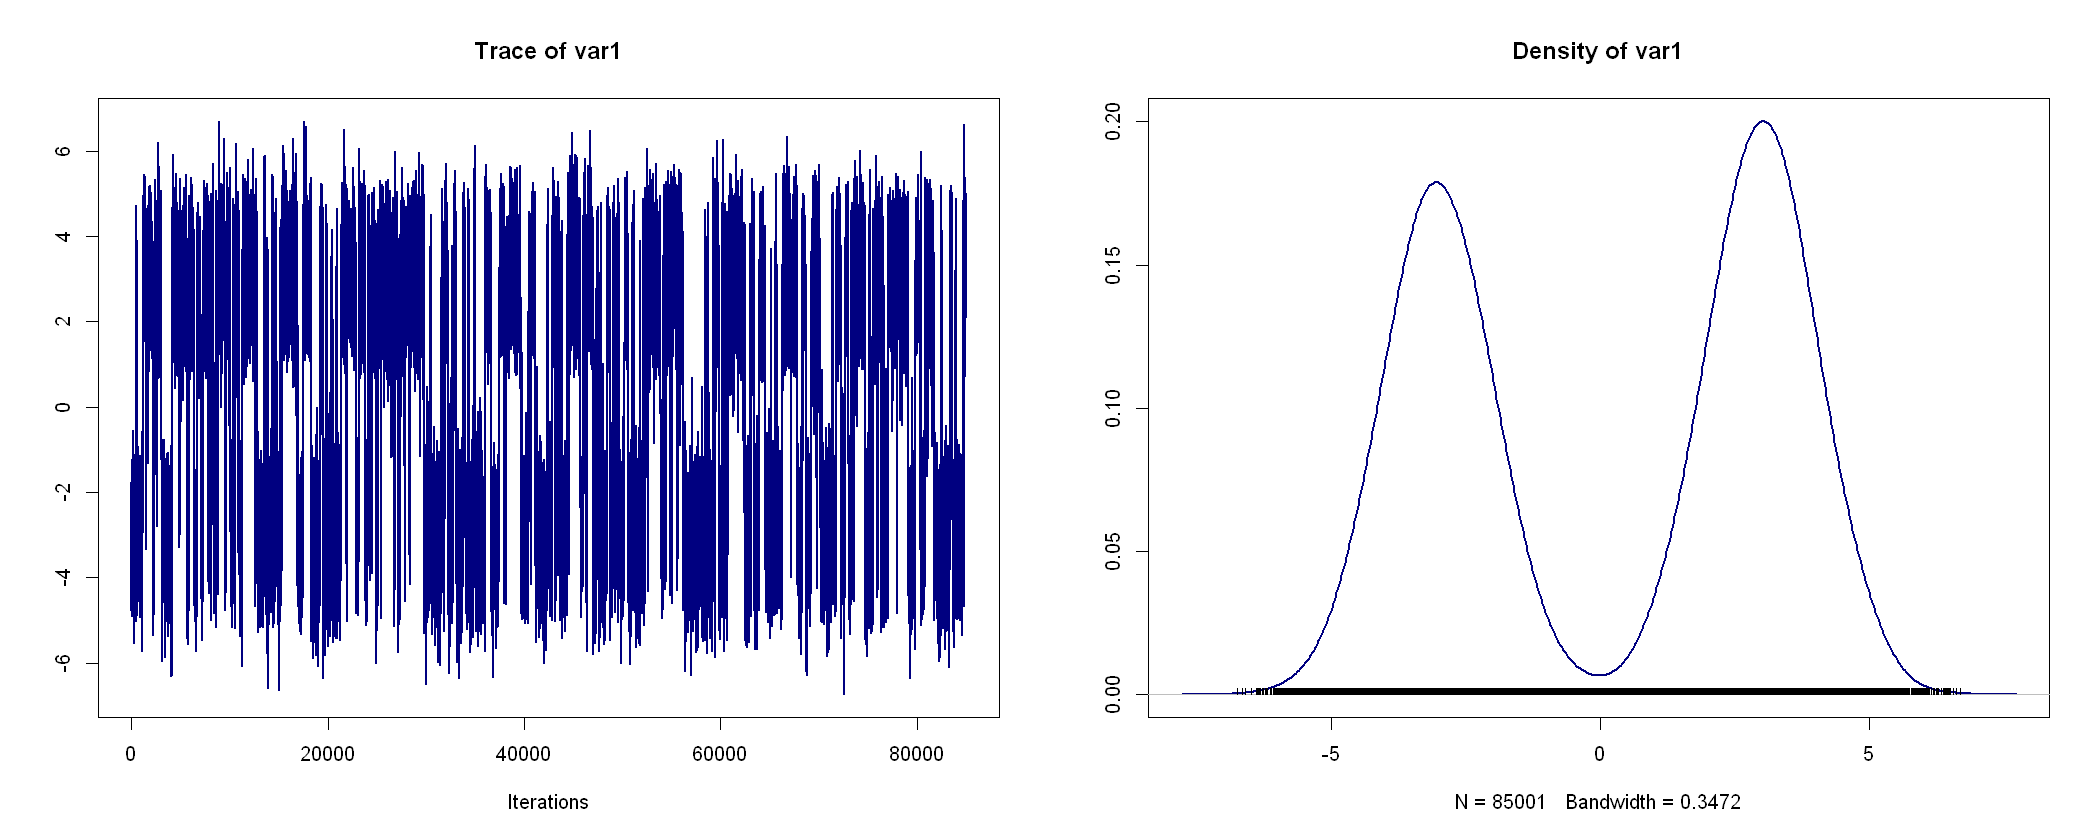

In [9]:
plot(my.lags, y1, pch=19, col='navy', xlab='lag', ylab='ACF', cex=1.3, main='Autocorrelation')

# Additional diagnostic plots
plot(test.mcmc, col='navy', lwd=2)


----------------

Instead of looking for the best set of parameters by printing the plots, I built a simple grid-search.
In the first GS I only check which couple of `burn.in` and `thinning` returns the mean that is closest to 0 and the sd that is closest to 3.  
Checking also autocorrelation is a bit too stringent. We can find one ACF value lower than another but it is not certain that the mean and sd values are closest to the true values (and most of the time we are stuck in the first parameters' couple).
Moreover, the trend of the ACF is similar in all cases for the chosen values.  

Must be noted that even if I set a seed for random generation, each mcmc with the same parameters will give slightly different results from the ones from the GS.

In [10]:
# Grid search function
grid_search <- function(burn.in.values, thinning.values, n.iter, post.func, mu.init) {

    
    chain.i <- my.mcmc(post.func, mu.init, n.iter, burn.in.values[1], thinning.values[1])
    chain.i <- as.data.frame(chain.i)
    colnames(chain.i) <- c('it', 'theta', 'n.acc', 'acc.rate')
    
    # theta_mcmc.i <- coda::mcmc(chain.i$theta)
    # my.lags <- seq(0, length(theta_mcmc.i)-1, 10)
    
    # acf.i <- autocorr.diag(theta_mcmc.i, lags=my.lags)
    # acf1.i <- mean(acf.i[10:length(acf.i)])  
    # mean_val.i <- mean(chain.i$theta)
    # sd_val.i <- sd(chain.i$theta)

    # cat('meanA', mean_val.i)
    # cat('sdA', sd_val.i)
    # cat('acfA', acf1.i)
    # cat('\n')

    # if (is.na(mean_val.i) | is.na(sd_val.i)) {break}
    
    # best_params <- list(burn.in = burn.in.values[1], thinning = thinning.values[1], 
    #                     acf = acf1.i, mean = mean_val.i, sd = sd_val.i)

    best_params <- list(burn.in = NULL, thinning = NULL, 
                        acf = Inf, mean = Inf, sd = NULL)
    
    for (burn.in in burn.in.values) {
        for (thinning in thinning.values) {
            chain <- my.mcmc(post.func, mu.init, n.iter, burn.in, thinning)
            chain <- as.data.frame(chain)
            colnames(chain) <- c('it', 'theta', 'n.acc', 'acc.rate')
            
            theta_mcmc <- coda::mcmc(chain$theta)
            
            acf <- autocorr.diag(theta_mcmc, lags=my.lags)
            acf1 <- mean(acf[10:length(acf)])
            
            
            mean_val <- mean(chain$theta)
            sd_val <- sd(chain$theta)

            if (is.na(mean_val) | is.na(sd_val)) {break}

            # cat('mean', abs(best_params$mean - mean_val))
            # cat('min', abs(mean_val - sd_val + 3))
            # cat('max', abs(mean_val + sd_val - 3))
            # cat('\n')
            
            # cat('mean', mean_val)
            # cat('sd', sd_val)
            # cat('acf', acf1)
            # cat('\n')
            
            if (
              abs(mean_val) < abs(best_params$mean) && 
              abs(sd_val - 3) < 0.15) {
              
            best_params <- list(burn.in = burn.in, thinning = thinning, acf = acf1, mean = mean_val, sd = sd_val)
            }
        }
    }
    
    return(best_params)
}

In [11]:
# Define the grid values for burn-in and thinning
burn.in.values <- seq(0, 0.5, by=0.05)
thinning.values <- c(1, 25, 50, 100)

# Initial value for theta
theta.init <- rnorm(1, 0, 1)

# Perform grid search
best_params <- grid_search(burn.in.values, thinning.values, n.iter = 100000, post.func, theta.init)

# Output the best parameters
print(best_params)

$burn.in
[1] 0.45

$thinning
[1] 100

$acf
[1] 0.0006551584

$mean
[1] 0.0002850688

$sd
[1] 3.149837



In [45]:
best.chain <- my.mcmc(func = post.func, mu.init = rnorm(1,0,1), n.iter = 100000, 
                      burn.in = best_params$burn.in, thinning = best_params$thinning, norm=F)

best.chain <- as.data.frame(best.chain)
colnames(best.chain) <- c('it', 'theta', 'n.acc', 'acc.rate')

In [46]:
posterior.mean <- mean(best.chain$theta) # must be centered in 0

posterior.sd <- sd(best.chain$theta)
x_min <- posterior.mean - posterior.sd # true value is x=-3
x_max <- posterior.mean + posterior.sd # true value is x=+3

cat("Posterior Mean:", round(posterior.mean, 2), "\n")
cat("Posterior Standard Deviation:", round(posterior.sd, 2), "\n")
print(sprintf("Firs max is at x=%.2f Second max is at x=%.2f", x_min, x_max))

Posterior Mean: 0.07 
Posterior Standard Deviation: 3.13 
[1] "Firs max is at x=-3.06 Second max is at x=3.20"


In [47]:
best.mcmc <- coda::mcmc(best.chain$theta)
my.lags <- seq(0, length(best.mcmc)-1, 10)
best.acf <- autocorr(best.mcmc, lags=my.lags)

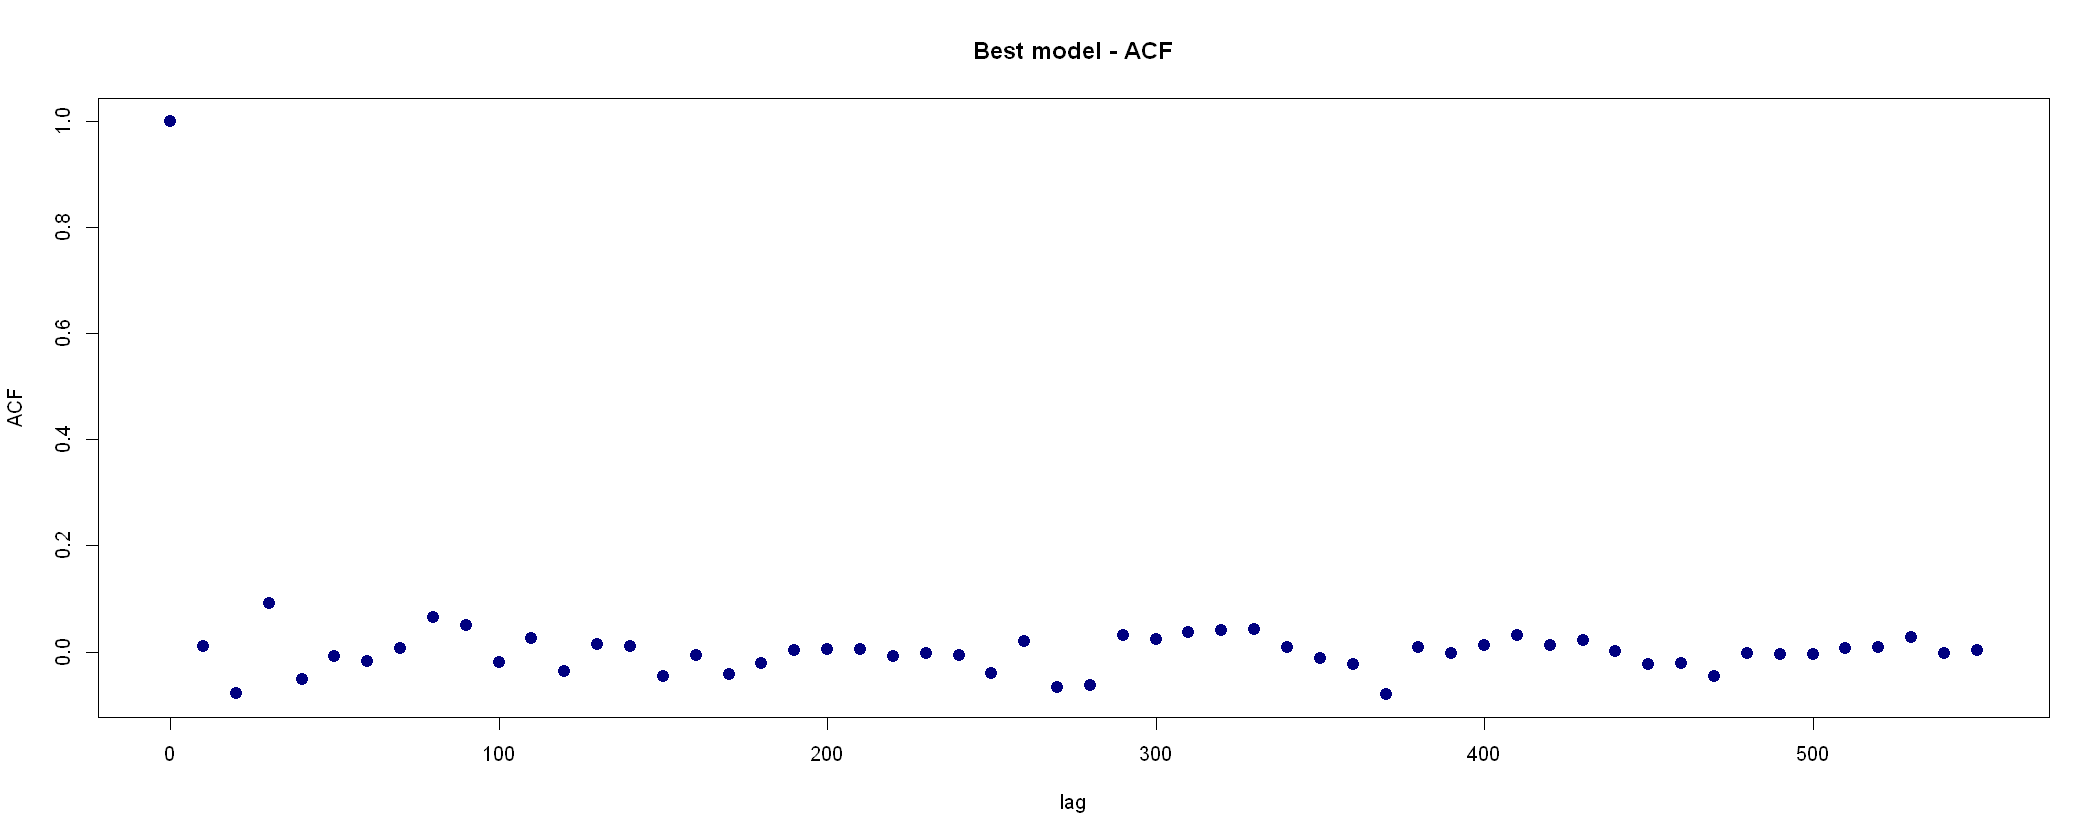

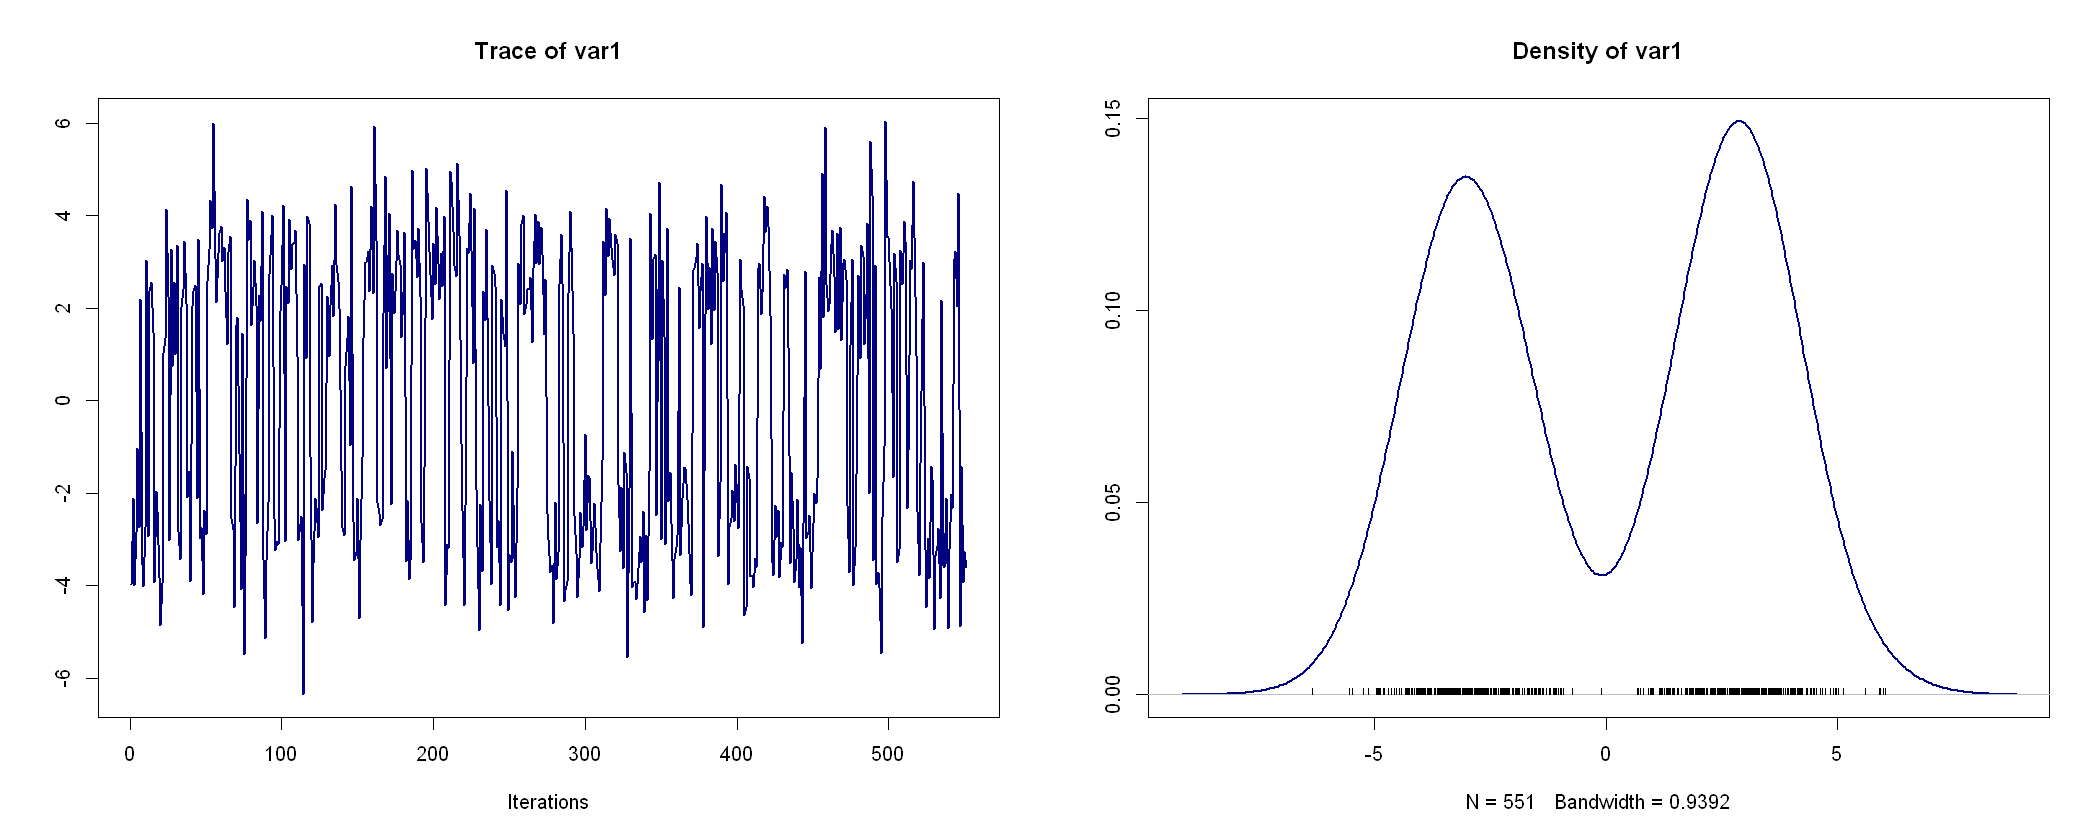

In [48]:
plot(my.lags, best.acf, pch=19, col='navy', xlab='lag', ylab='ACF', cex=1.3, main='Best model - ACF')

# Additional diagnostic plots
plot(best.mcmc, col='navy', lwd=2)

#### 2)

In [175]:
# Create data object
data1 <- list(
  Y = c(-7.821, -1.494, -15.444, -10.807, -13.735, -14.442, -15.892, -18.326),
  X = c(5, 6, 7, 8, 9, 10, 11, 12)
)

# Define the model in JAGS syntax
model1 <- 'jm_ex5.2.bug'

jm1 <- jags.model(model1, data1)
update(jm1, 500) #burnin

chain1 <- coda.samples(jm1, c("a", "b", "c"), n.iter=10000, thin=15)

# Summarize the results
print(summary(chain1))

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 8
   Unobserved stochastic nodes: 3
   Total graph size: 41

Initializing model


Iterations = 1515:11490
Thinning interval = 15 
Number of chains = 1 
Sample size per chain = 666 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean       SD  Naive SE Time-series SE
a  1.45704 0.453897 0.0175881      0.0190075
b -0.94568 0.053264 0.0020639      0.0021583
c  0.04429 0.009788 0.0003793      0.0004061

2. Quantiles for each variable:

      2.5%      25%     50%      75%    97.5%
a  1.01267  1.11914  1.3095  1.64356  2.73242
b -0.99849 -0.98363 -0.9639 -0.92235 -0.80824
c  0.03435  0.03753  0.0409  0.04848  0.07248



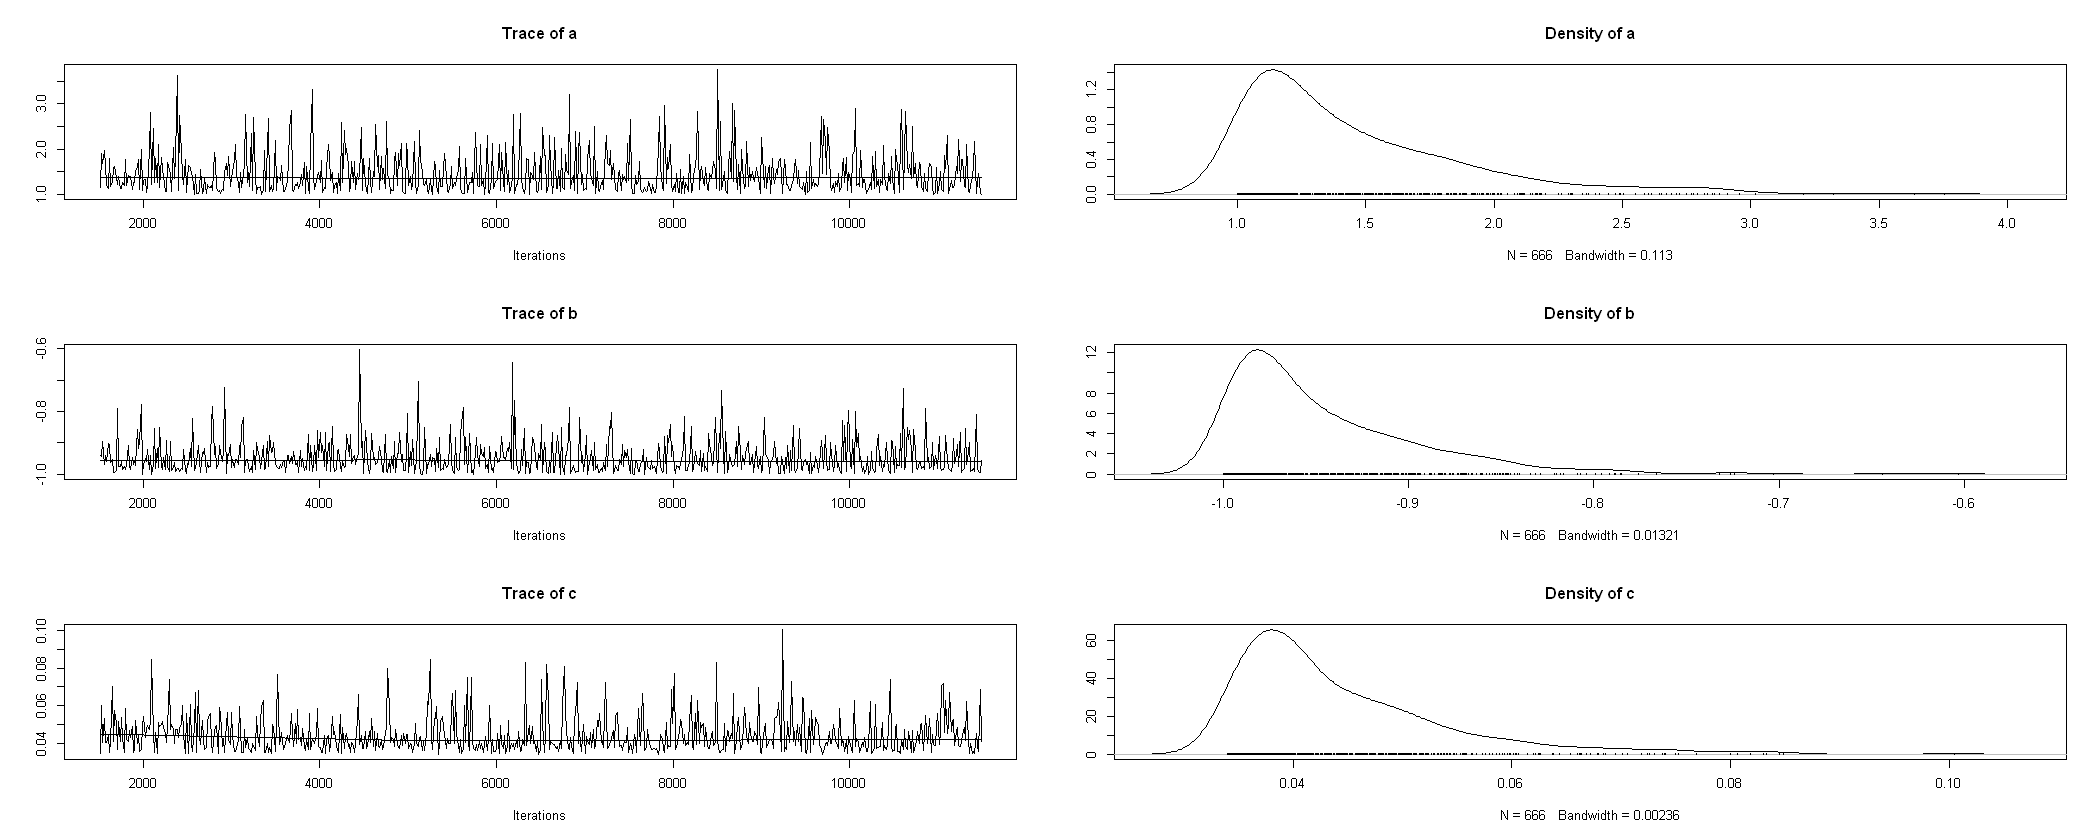

In [176]:
plot(chain1)

In [177]:
a.mean <- summary(chain1)$statistics[1,1]
b.mean <- summary(chain1)$statistics[2,1]
c.mean <- summary(chain1)$statistics[3,1]

print(sprintf('Candidate value for a is: %.2f', a.mean))
print(sprintf('Candidate value for b is: %.2f', b.mean))
print(sprintf('Candidate value for c is: %.2f', c.mean))
cat('\n')

a.sd <- summary(chain1)$statistics[2,1]
b.sd <- summary(chain1)$statistics[2,2]
c.sd <- summary(chain1)$statistics[2,3]

a.ci.lo <- summary(chain1)$quantiles[1,1]
a.ci.hi <- summary(chain1)$quantiles[1,5]
b.ci.lo <- summary(chain1)$quantiles[2,1]
b.ci.hi <- summary(chain1)$quantiles[2,5]
c.ci.lo <- summary(chain1)$quantiles[3,1]
c.ci.hi <- summary(chain1)$quantiles[3,5]

print(sprintf('a 0.95 CI is [%.2f, %.2f]', a.ci.lo, a.ci.hi))
print(sprintf('b 0.95 CI is [%.2f, %.2f]', b.ci.lo, b.ci.hi))
print(sprintf('c 0.95 CI is [%.2f, %.2f]', c.ci.lo, c.ci.hi))

[1] "Candidate value for a is: 1.46"
[1] "Candidate value for b is: -0.95"
[1] "Candidate value for c is: 0.04"

[1] "a 0.95 CI is [1.01, 2.73]"
[1] "b 0.95 CI is [-1.00, -0.81]"
[1] "c 0.95 CI is [0.03, 0.07]"


In [178]:
lin.reg <- function(X, a, b) {
    return(a + b * X)
}

num <- seq(0, 15, 1)
z.fit <- lin.reg(num, a.mean, b.mean)
data.fit <- data.frame(num = num, z.fit = z.fit)

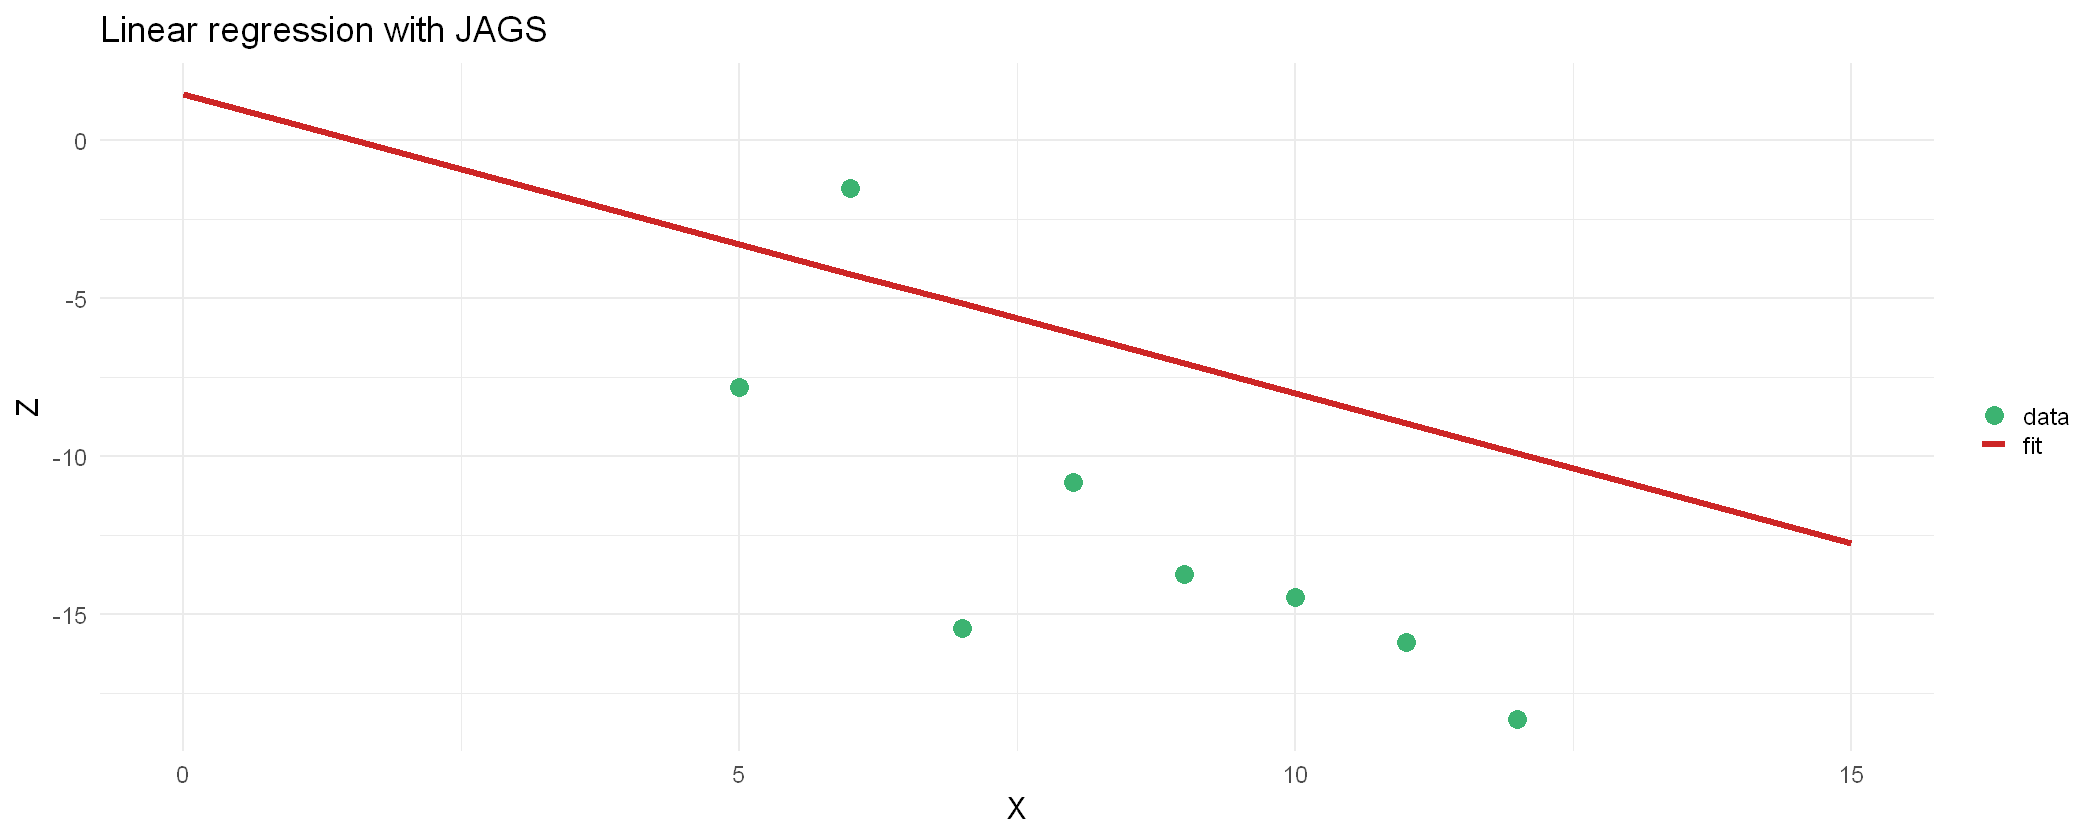

In [179]:
interp <- ggplot() + 
    geom_point(aes(x=data1$X, y=data1$Y, color='data'), size=5) +
    geom_line(aes(x=data.fit$num, y=data.fit$z.fit, color='fit'), lwd=1.7) +
    labs(title='Linear regression with JAGS', x='X', y='Z', color='') + 
    theme_minimal(base_size = 18) +
	scale_color_manual(values=c('data'= 'mediumseagreen', 'fit'= 'firebrick3' ))

interp

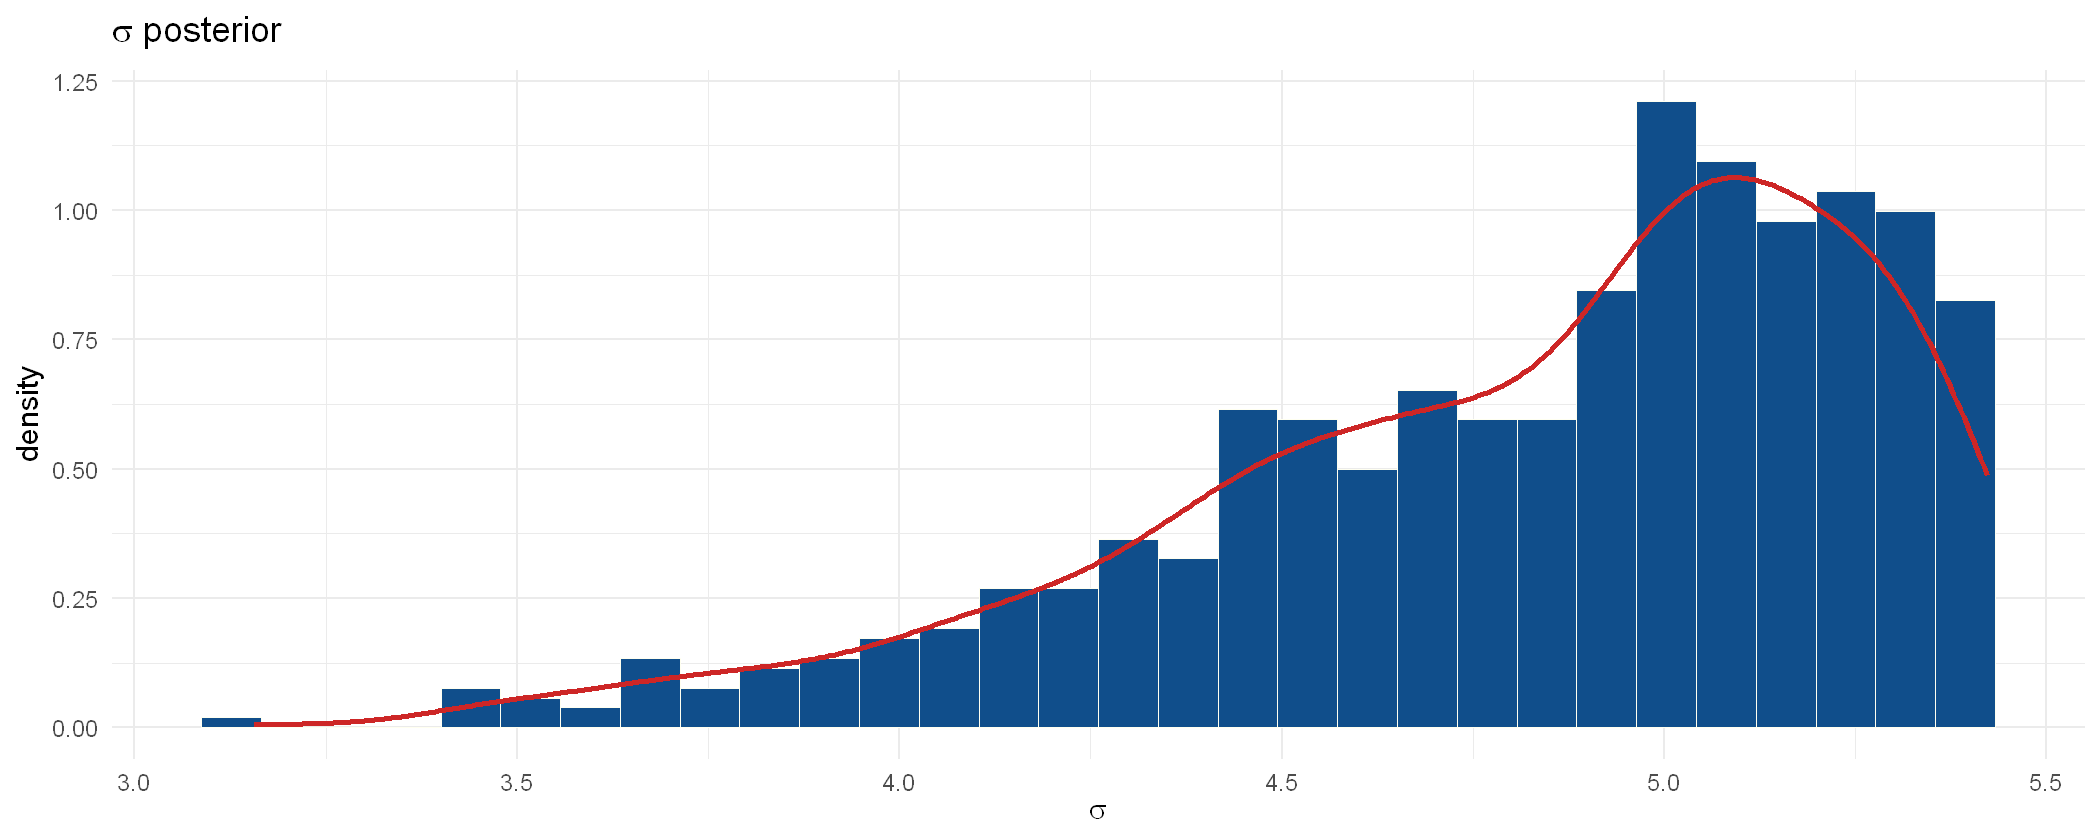

In [183]:
chain1.df <- as.data.frame(as.mcmc(chain1))

c_samples <- chain1.df$c  # Assuming 'sigma.sq' represents c in your model


sigma_samples <- 1 / sqrt(c_samples)

sigma.post <- ggplot() + 
    geom_histogram(aes(x=sigma_samples, after_stat(density)), bins = 30, color = "ivory", fill = "dodgerblue4") + 
    geom_density(aes(x=sigma_samples), color = "firebrick3", lwd = 1.5) + 
    labs(title=TeX(r'(\sigma posterior)'), x=TeX(r'(\sigma)')) +
    theme_minimal(base_size = 18)

sigma.post

#### 3)

In [171]:
# Create data object
data2 <- list(
  x = c(2.06, 5.56, 7.93, 6.56, 2.05)
)

# Define the model in JAGS syntax
model2 <- 'jm_ex5.3.bug'

jm2 <- jags.model(model2, data2)
update(jm2, 500) #burnin

chain2 <- coda.samples(jm2, c("m", "s"), n.iter=10000, thin=15)

# Summarize the results
print(summary(chain2))

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 5
   Unobserved stochastic nodes: 2
   Total graph size: 11

Initializing model


Iterations = 1515:11490
Thinning interval = 15 
Number of chains = 1 
Sample size per chain = 666 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

    Mean     SD Naive SE Time-series SE
m 4.8312 1.1318 0.043858       0.043858
s 0.2095 0.1251 0.004848       0.004848

2. Quantiles for each variable:

     2.5%    25%    50%    75%  97.5%
m 2.76872 4.0837 4.8256 5.4838 7.1604
s 0.04852 0.1159 0.1832 0.2758 0.5096



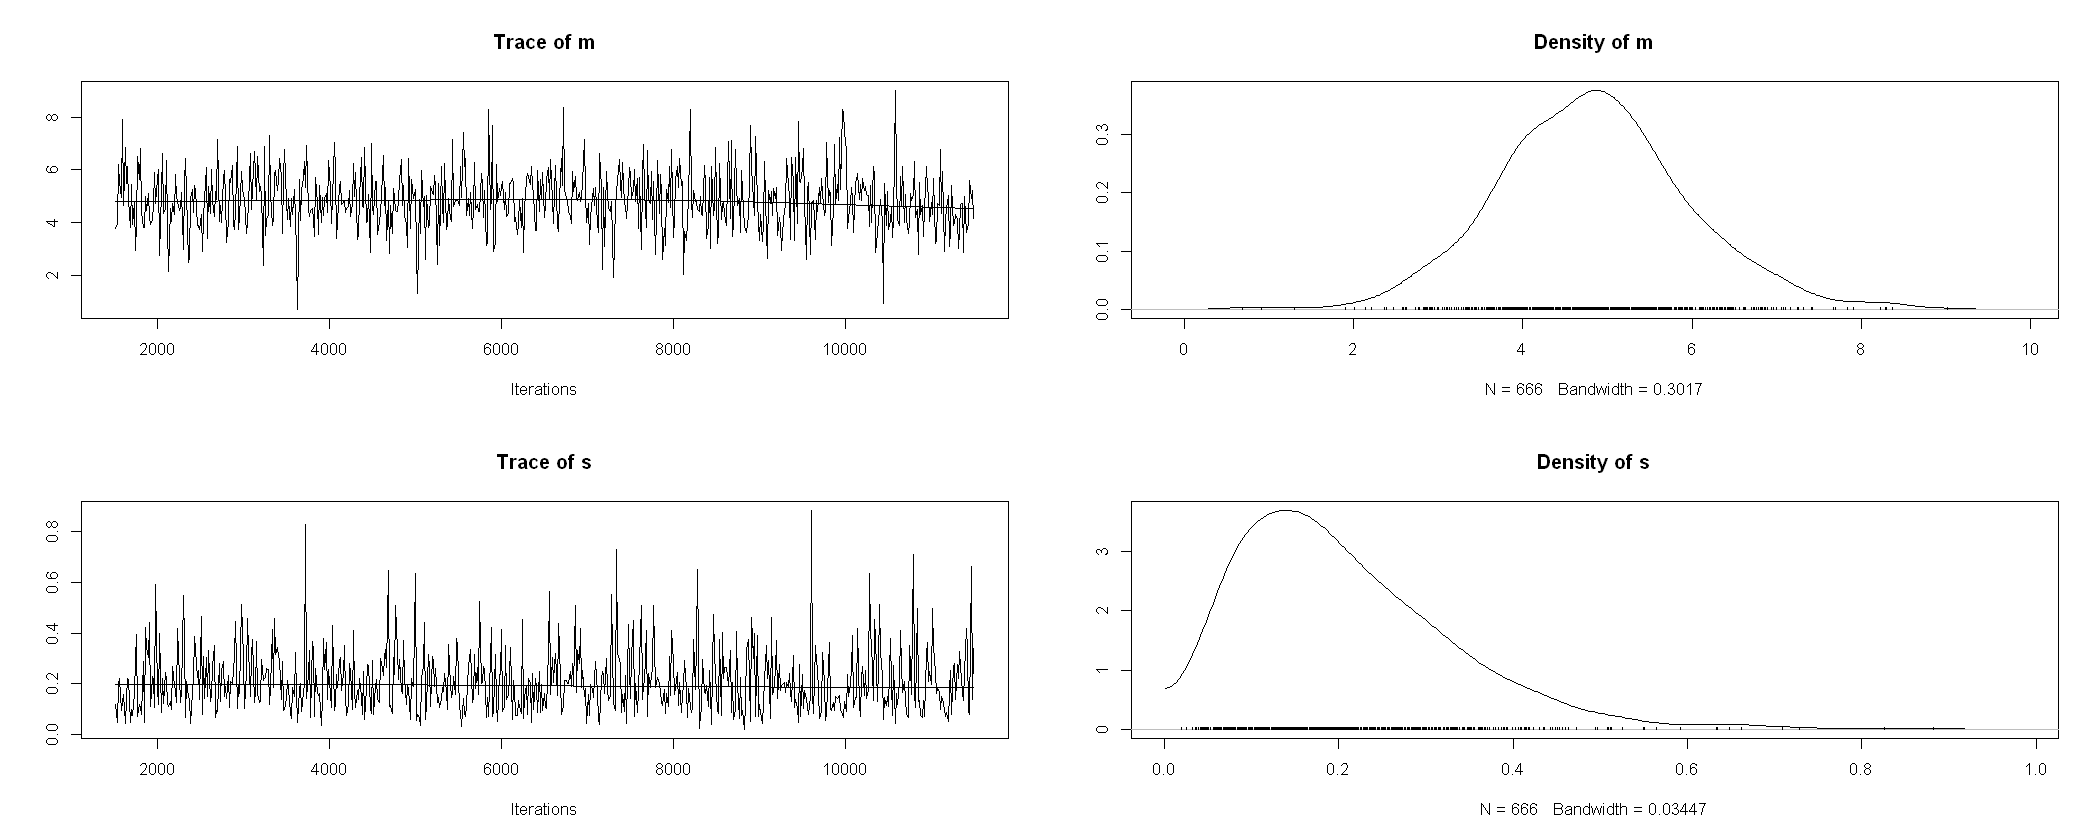

In [172]:
plot(chain2)

In [174]:
m.mean <- summary(chain2)$statistics[1,1]
s.mean <- summary(chain2)$statistics[2,1]

print(sprintf('Candidate value for m is: %.2f', m.mean))
print(sprintf('Candidate value for s is: %.2f', s.mean))
cat('\n')

m.sd <- summary(chain2)$statistics[2,1]
s.sd <- summary(chain2)$statistics[2,2]

m.ci.lo <- summary(chain2)$quantiles[1,1]
m.ci.hi <- summary(chain2)$quantiles[1,5]
s.ci.lo <- summary(chain2)$quantiles[2,1]
s.ci.hi <- summary(chain2)$quantiles[2,5]

print(sprintf('m 0.95 CI is [%.2f, %.2f]', m.ci.lo, m.ci.hi))
print(sprintf('s 0.95 CI is [%.2f, %.2f]', s.ci.lo, s.ci.hi))

[1] "Candidate value for m is: 4.83"
[1] "Candidate value for s is: 0.21"

[1] "m 0.95 CI is [2.77, 7.16]"
[1] "s 0.95 CI is [0.05, 0.51]"


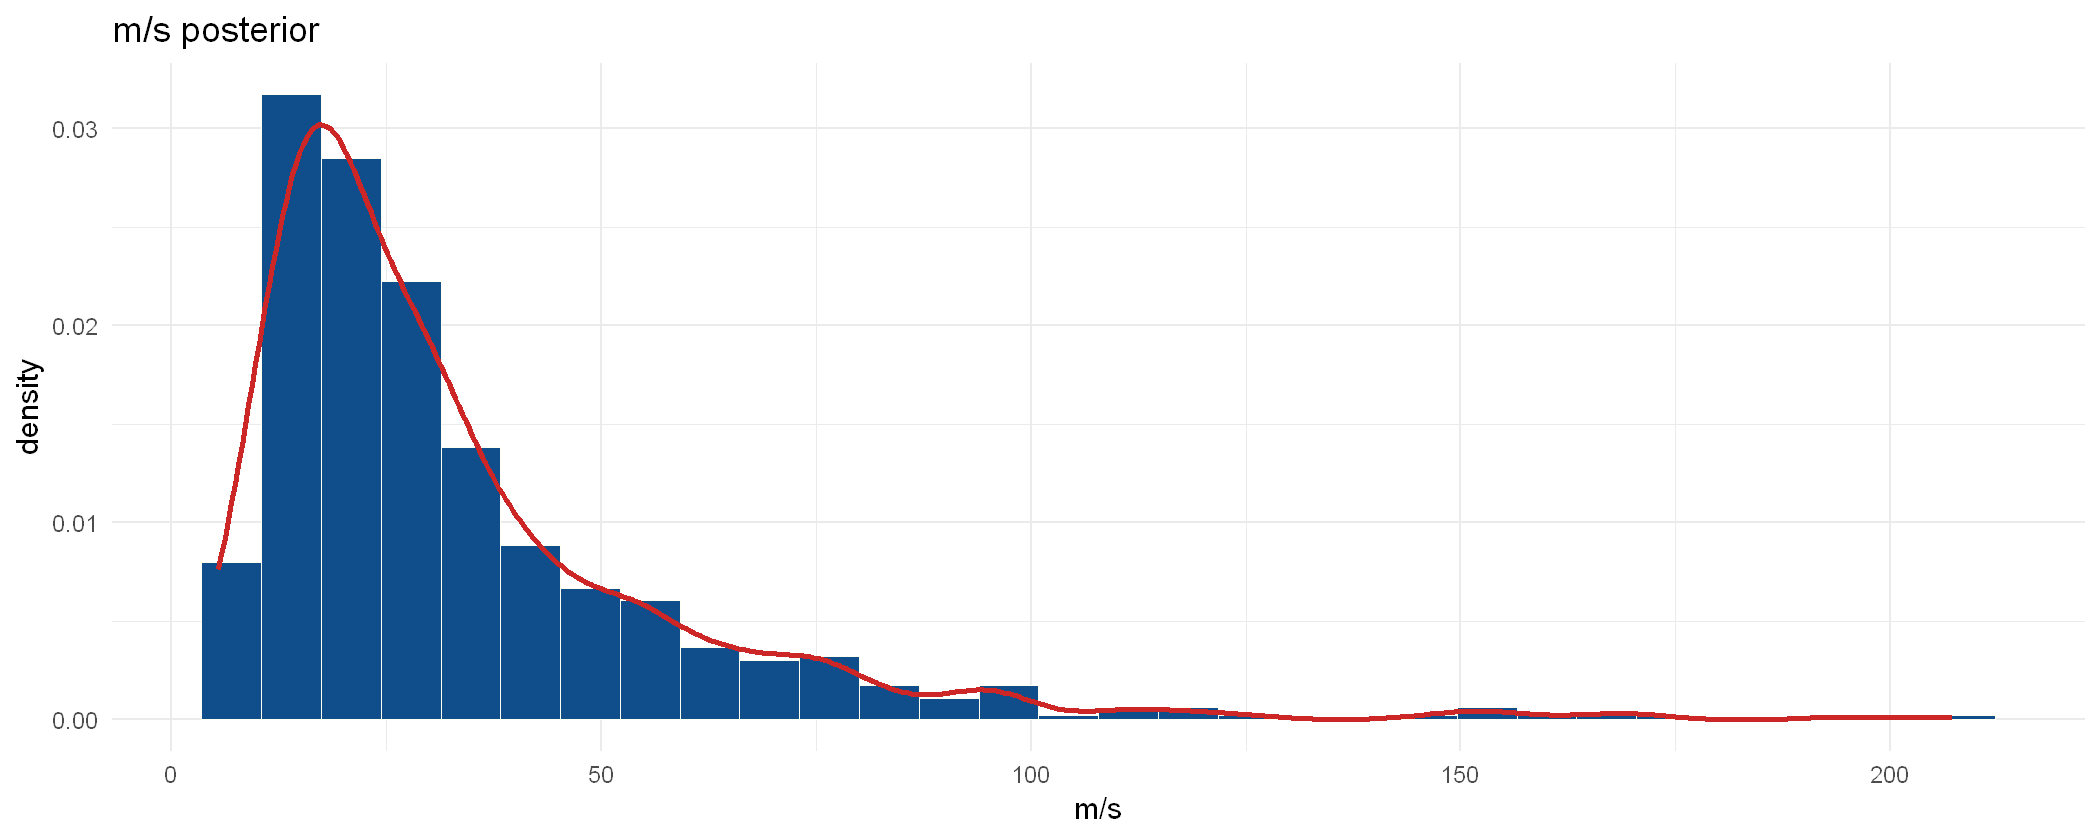

In [184]:
chain2.df <- as.data.frame(as.mcmc(chain2))

param.ratio <- chain2.df$m / chain2.df$s

ratio.post <- ggplot() + 
    geom_histogram(aes(x=param.ratio, after_stat(density)), bins = 30, color = "ivory", fill = "dodgerblue4") + 
    geom_density(aes(x=param.ratio), color = "firebrick3", lwd = 1.5) + 
    labs(title='m/s posterior', x='m/s') +
    theme_minimal(base_size = 18)

ratio.post